# Generative Adversarial Network for simple sinusoidal data
Following the example from: <br>
https://realpython.com/generative-adversarial-networks/

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [2]:
# generate random seed
torch.manual_seed(111)

### Prepare training data

In [3]:
# The training data is composed of pairs (x₁, x₂) so that x₂
# consists of the value of the sine of x₁ for x₁ in the interval from 0 to 2π.

train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

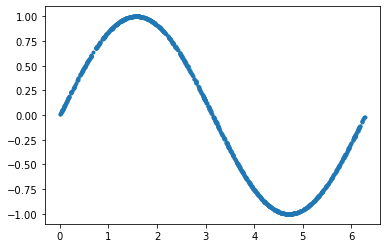

In [4]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [5]:
# create a python dataloader
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

### Build network

In [6]:
# build discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
# build generative network
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

### Train model

In [8]:
# create discriminator and generator
discriminator = Discriminator()
generator = Generator()
# hyperparameters
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()
# optimizer
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [9]:
# start the training loop
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.19106775522232056
Epoch: 0 Loss G.: 1.8886789083480835
Epoch: 10 Loss D.: 0.6593940854072571
Epoch: 10 Loss G.: 0.9345511198043823
Epoch: 20 Loss D.: 0.7037724852561951
Epoch: 20 Loss G.: 0.8252997398376465
Epoch: 30 Loss D.: 0.5847079157829285
Epoch: 30 Loss G.: 1.0379650592803955
Epoch: 40 Loss D.: 0.6499709486961365
Epoch: 40 Loss G.: 0.7380998134613037
Epoch: 50 Loss D.: 0.6576102375984192
Epoch: 50 Loss G.: 0.6966965198516846
Epoch: 60 Loss D.: 0.6608182191848755
Epoch: 60 Loss G.: 0.6863024234771729
Epoch: 70 Loss D.: 0.6956440210342407
Epoch: 70 Loss G.: 0.6437080502510071
Epoch: 80 Loss D.: 0.7065955996513367
Epoch: 80 Loss G.: 0.6857181787490845
Epoch: 90 Loss D.: 0.6651331782341003
Epoch: 90 Loss G.: 0.6882128715515137
Epoch: 100 Loss D.: 0.702793300151825
Epoch: 100 Loss G.: 0.824127733707428
Epoch: 110 Loss D.: 0.7003846168518066
Epoch: 110 Loss G.: 0.744504451751709
Epoch: 120 Loss D.: 0.6606516242027283
Epoch: 120 Loss G.: 0.7405065298080444
Epoch: 130

### Checking the Samples Generated by the GAN

In [10]:
# sample latent space
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

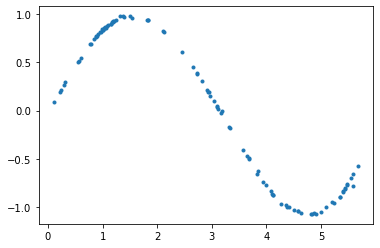

In [11]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")